<a href="https://colab.research.google.com/github/mili189/ASK2026_Semiconductor_FDC/blob/main/ASK2026_Semiconductor_FDC%20/LSTM%20Autoencoder%20/New%EC%A0%84%EC%B2%98%EB%A6%AC_LSTM_%EB%AA%A8%EB%8D%B8_%EA%B5%AC%ED%98%84.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
import os


drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy.interpolate import interp1d

# Machine Data 로드
file_path = ("/content/drive/MyDrive/Colab Notebooks/data set/MACHINE_data/MACHINE_Data.xlsx")

# df 변수에 파일 로드 (데이터셋은 엑셀 파일로 공유드렸기 때문에 xlsx, csv 확장자로 이루어져야 함)
if os.path.exists(file_path):
    print(f"{file_path}")
    if file_path.endswith('.xlsx'):
        df = pd.read_excel(file_path)
    elif file_path.endswith('.csv'):
        df = pd.read_csv(file_path)
    else:
        print("지원하지 않는 파일 형식입니다.")
else:
    raise FileNotFoundError(f"File not found: {file_path}")

# Machine Data의 전체 행열 표기
print(f"Machine Data 로드 완료. Shape: {df.shape}")

# 식별 및 정답 Column
meta_cols = ['Wafer_ID', 'Time_Step', 'Label', 'Fault_Type', 'Time', 'Step Number']

# 학습에 사용할 센서 변수 선택 (센서 데이터만 선택)
sensor_cols = [c for c in df.columns if c not in meta_cols]
# 문자열 데이터 필터링 추가
sensor_cols = df[sensor_cols].select_dtypes(include=[np.number]).columns.tolist()

print(f"선택된 센서 변수 ({len(sensor_cols)}개):")
print(sensor_cols)

/content/drive/MyDrive/Colab Notebooks/data set/MACHINE_data/MACHINE_Data.xlsx
Machine Data 로드 완료. Shape: (12829, 25)
선택된 센서 변수 (19개):
['BCl3 Flow', 'Cl2 Flow', 'RF Btm Pwr', 'RF Btm Rfl Pwr', 'Endpt A', 'He Press', 'Pressure', 'RF Tuner', 'RF Load', 'RF Phase Err', 'RF Pwr', 'RF Impedance', 'TCP Tuner', 'TCP Phase Err', 'TCP Impedance', 'TCP Top Pwr', 'TCP Rfl Pwr', 'TCP Load', 'Vat Valve']


In [ ]:
#데이터 전처리
# 설정 변수
FIXED_LENGTH = 100  # Time Steps 통일
n_features = len(sensor_cols)   # 센서 변수의 총 개수

# 전처리 함수 정의
# df: 데이터셋 저장 변수
# wafer_col: 웨이퍼를 구별하는 ID Column 이름(Wafer_ID)
# sensor_cols: 센서 데이터의 고유 이름이 저장되어 있는 리스트
# target_len: 시간 길이(FIXED_LENGTH)
def preprocess_to_3d(df, wafer_col, sensor_cols, target_len):

    # Wafer_ID 추출
    wafer_ids = df[wafer_col].unique()
    data_list = []   # 센서 데이터 저장 (X축)
    label_list = []  # 정상/불량 라벨 저장 (Y축)

    print(f"총 웨이퍼 수: {len(wafer_ids)}개")

    # 하나의 단일 웨이퍼 씩 처리
    for wid in wafer_ids:
        # 특정 웨이퍼의 데이터 추출
        wafer_df = df[df[wafer_col] == wid]

        # 1. 라벨링 저장 (Normal/Fault)
        label = 1 if wafer_df['Label'].iloc[0] == 'Normal' else 0
        label_list.append(label)

        # 2. 센서 데이터의 보간법 (길이 맞추기)
        sensor_data = wafer_df[sensor_cols].values # (Current_Len, Features)
        current_len = len(sensor_data)

        if current_len == 0: continue

        # 시간 축 정규화(0 ~ 1로 변환)(Interporation)(93s의 공정이라면)
        x_old = np.linspace(0, 1, current_len)  # 센서 데이터를 0 ~ 93으로 나타냄
        x_new = np.linspace(0, 1, target_len)   # 센서 데이터를 0 ~ 100으로 보간함

        # 보간 함수 생성 및 데이터 재생성
        f = interp1d(x_old, sensor_data, axis=0, kind='linear')   # 보간 함수(f)를 통해 x_old의 데이터 패턴을 저장함
        data_resized = f(x_new) # x_new를 입력하여 x_old의 데이터 패턴을 반영된 데이터를 재생성함

        data_list.append(data_resized)

    return np.array(data_list), np.array(label_list)

# 함수 실행 (3차원 배열 생성)
# X_raw: 3차원 센서 데이터, y_labels: 라벨 데이터
X_raw, y_labels = preprocess_to_3d(df, 'Wafer_ID', sensor_cols, FIXED_LENGTH)

print(f"\n변환 완료 형태 (Shape): {X_raw.shape}")
print(f"(Samples: {X_raw.shape[0]}, TimeSteps: {X_raw.shape[1]}, Features: {X_raw.shape[2]})")

총 웨이퍼 수: 129개

변환 완료 형태 (Shape): (129, 100, 19)
(Samples: 129, TimeSteps: 100, Features: 19)


In [ ]:
# 1. 3차원 -> 2차원 변환 (MinMax스케일러는 2차원 데이터로만 입력받을 수 있음)
n_samples, n_steps, n_feats = X_raw.shape
X_2d = X_raw.reshape(-1, n_feats)       # 변환 후: (12900행, 19열) = (129웨이퍼 x 100초, 19개의 센서데이터)

# 2. MinMax 스케일링 (센서 데이터의 최소값, 최대값을 기준으로 0부터 1까지 스케일링함)
scaler = MinMaxScaler()
X_scaled_2d = scaler.fit_transform(X_2d)

# 3. 다시 3차원으로 복원
X_final = X_scaled_2d.reshape(n_samples, n_steps, n_feats)

print("정규화 완료. 데이터 범위:", np.min(X_final), "~", np.max(X_final))

정규화 완료. 데이터 범위: 0.0 ~ 1.0


In [ ]:
# Wafer_ID 저장
wafer_ids = df['Wafer_ID'].unique()

# Wafer_ID의 개수가 X_final의 샘플 수와 같아야 함
print(f"전체 웨이퍼 개수: {len(wafer_ids)}")
print(f"데이터셋 크기: {X_final.shape[0]}")

전체 웨이퍼 개수: 129
데이터셋 크기: 129


In [ ]:
from sklearn.model_selection import train_test_split

# 테스트셋과 학습셋은 정상 데이터로만 이루어져 있고 불량 데이터은 따로 X_fault로 출력됨
def create_dataset_for_experiment(exp_num, X_all, y_all, ids_all):
    # 특정 실험 번호에 해당하는 데이터만 선별하여 학습셋, 테스트셋을 만듭니다.

    print(f"\n======== [Experiment {exp_num}] 데이터셋 생성 ========")

    # 1. 해당 실험에 속하는 인덱스 찾기 (예: 'l29'로 시작하는 ID 찾기)
    # startswith를 사용하여 실험 번호 구분
    exp_indices = [i for i, wid in enumerate(ids_all) if wid.startswith(exp_num)]

    if len(exp_indices) == 0:
        print("해당 실험 데이터를 찾을 수 없습니다.")
        return None, None, None

    # 2. 해당 실험의 데이터만 추출
    X_exp = X_all[exp_indices]
    y_exp = y_all[exp_indices]

    print(f"  > 전체 샘플 수: {len(X_exp)}개")

    # 3. 정상(1) / 불량(0) 분리
    normal_idx = np.where(y_exp == 1)[0]
    fault_idx = np.where(y_exp == 0)[0]

    X_normal = X_exp[normal_idx]
    X_fault = X_exp[fault_idx]

    print(f"  > 정상: {len(X_normal)}개, 불량: {len(X_fault)}개")

    # 4. 학습셋 / 테스트셋 분할 (정상 데이터만 8:2로 분할)
    # random_state를 고정하여 재현성 확보
    X_train, X_test_normal = train_test_split(X_normal, test_size=0.2, random_state=42)

    # 5. 불량 데이터는 전량 테스트용으로 사용 (학습하지 않음)
    # 반환값: 학습셋(정상), 테스트셋(정상), 테스트셋(불량)
    return X_train, X_test_normal, X_fault

# -----------------------------------------------------------
# 실행: 실험 29, 31, 33에 대해 각각 데이터셋 생성
# -----------------------------------------------------------

# 결과를 저장할 딕셔너리
datasets = {}

# 데이터의 실험 번호 확인: 'l29', 'l31', 'l33' (소문자 l + 실험 번호)
experiments = ['l29', 'l31', 'l33']

for exp_id in experiments:
    # 함수 실행
    X_train_exp, X_test_norm_exp, X_test_fault_exp = create_dataset_for_experiment(
        exp_id, X_final, y_labels, wafer_ids
    )

    # 딕셔너리에 저장
    datasets[exp_id] = {
        'train': X_train_exp,
        'test_normal': X_test_norm_exp,
        'test_fault': X_test_fault_exp
    }


======== [Experiment l29] 데이터셋 생성 ========
  > 전체 샘플 수: 43개
  > 정상: 34개, 불량: 9개

======== [Experiment l31] 데이터셋 생성 ========
  > 전체 샘플 수: 43개
  > 정상: 37개, 불량: 6개

======== [Experiment l33] 데이터셋 생성 ========
  > 전체 샘플 수: 43개
  > 정상: 37개, 불량: 6개


In [ ]:
print("\n======== 최종 데이터셋 구성 확인 ========")

for exp_id in experiments:
    data = datasets[exp_id]
    if data['train'] is not None:
        print(f"[{exp_id} 실험]")
        print(f"  - 학습용 (Normal): {data['train'].shape}")
        print(f"  - 테스트 (Normal): {data['test_normal'].shape}")
        print(f"  - 테스트 (Fault) : {data['test_fault'].shape}")

        print(f"  - 학습 데이터는 순수 정상 데이터입니다.")
    else:
        print(f"[{exp_id} 실험] 데이터 없음 (ID 확인 필요)")


======== 최종 데이터셋 구성 확인 ========
[l29 실험]
  - 학습용 (Normal): (27, 100, 19)
  - 테스트 (Normal): (7, 100, 19)
  - 테스트 (Fault) : (9, 100, 19)
  - 학습 데이터는 순수 정상 데이터입니다.
[l31 실험]
  - 학습용 (Normal): (29, 100, 19)
  - 테스트 (Normal): (8, 100, 19)
  - 테스트 (Fault) : (6, 100, 19)
  - 학습 데이터는 순수 정상 데이터입니다.
[l33 실험]
  - 학습용 (Normal): (29, 100, 19)
  - 테스트 (Normal): (8, 100, 19)
  - 테스트 (Fault) : (6, 100, 19)
  - 학습 데이터는 순수 정상 데이터입니다.


In [ ]:
#논문에서 사용한 stacked LSTM Autoencoder 모델 구현
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
# 장치 설정 (GPU 사용 가능 시 CUDA, 아니면 CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class LAM9600_LSTM_AE(nn.Module):
    def __init__(self, n_features, seq_len):
        super(LAM9600_LSTM_AE, self).__init__()
        self.seq_len = seq_len
        self.n_features = n_features

        # [Encoder]
        # 입력 센서 수 -> 64 -> 32 -> 16 (압축)
        self.encoder_lstm1 = nn.LSTM(n_features, 64, batch_first=True)
        self.encoder_lstm2 = nn.LSTM(64, 32, batch_first=True)
        self.encoder_lstm3 = nn.LSTM(32, 16, batch_first=True) # Bottleneck Layer 논문에서는 32, 16 압축인데 성능이 안좋아서 8로 줄여봄

        # [Decoder]
        # 16 -> 32 -> 64 -> 입력 센서 수 (복원)
        self.decoder_lstm1 = nn.LSTM(16, 32, batch_first=True)
        self.decoder_lstm2 = nn.LSTM(32, 64, batch_first=True)
        self.output_layer = nn.Linear(64, n_features)

    def forward(self, x):
        # --- Encoding ---
        # enc1: (batch, seq_len, 64)
        enc1, _ = self.encoder_lstm1(x)
        # enc2: (batch, seq_len, 32)
        enc2, _ = self.encoder_lstm2(enc1)
        # enc3: 마지막 시점의 hidden state만 추출하여 잠재 벡터(Latent Vector)로 사용
        _, (hidden, _) = self.encoder_lstm3(enc2) # hidden: (1, batch, 16)

        # --- Repeat Vector ---
        # 마지막 특징(16차원)을 입력 시퀀스 길이(100)만큼 복제하여 디코더의 입력으로 전달
        repeat_x = hidden.repeat(self.seq_len, 1, 1).permute(1, 0, 2) # (batch, 100, 16)

        # --- Decoding ---
        dec1, _ = self.decoder_lstm1(repeat_x)
        dec2, _ = self.decoder_lstm2(dec1)
        # 최종 출력: (batch, 100, n_features)
        out = self.output_layer(dec2)
        return out

# 모델 파라미터 확인용 (실험 29 데이터 기준)
n_feats = datasets['l29']['train'].shape[2]
n_steps = datasets['l29']['train'].shape[1]

model = LAM9600_LSTM_AE(n_features=n_feats, seq_len=n_steps).to(device)
print(model)

LAM9600_LSTM_AE(
  (encoder_lstm1): LSTM(19, 64, batch_first=True)
  (encoder_lstm2): LSTM(64, 32, batch_first=True)
  (encoder_lstm3): LSTM(32, 16, batch_first=True)
  (decoder_lstm1): LSTM(16, 32, batch_first=True)
  (decoder_lstm2): LSTM(32, 64, batch_first=True)
  (output_layer): Linear(in_features=64, out_features=19, bias=True)
)


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import KFold

def plot_model_results(exp_id, title, y_true, y_pred, ai_scores, threshold):
    # 1. 혼동 행렬 시각화
    cm = confusion_matrix(y_true, y_pred, labels=[1, 0])
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
                xticklabels=['Normal', 'Fault'], yticklabels=['Normal', 'Fault'])
    plt.title(f'[{title}] Confusion Matrix')

    # 2. AI 분포 시각화 (논문 Fig. 5 스타일)
    plt.subplot(1, 2, 2)
    indices = np.arange(len(ai_scores))
    n_norm = sum(y_true)
    plt.scatter(indices[:n_norm], ai_scores[:n_norm], color='blue', label='Healthy', alpha=0.5)
    plt.scatter(indices[n_norm:], ai_scores[n_norm:], color='red', marker='x', label='Defective')
    plt.axhline(y=threshold, color='black', linestyle='--', label='Threshold')
    plt.title(f'[{title}] AI Distribution')
    plt.legend()
    plt.tight_layout()
    plt.show()

    acc = accuracy_score(y_true, y_pred)
    print(f"👉 {title} Accuracy: {acc*100:.2f}%")
    return acc


📊 실험 l29 비교 분석 시작

[Case A] Baseline 학습 중...


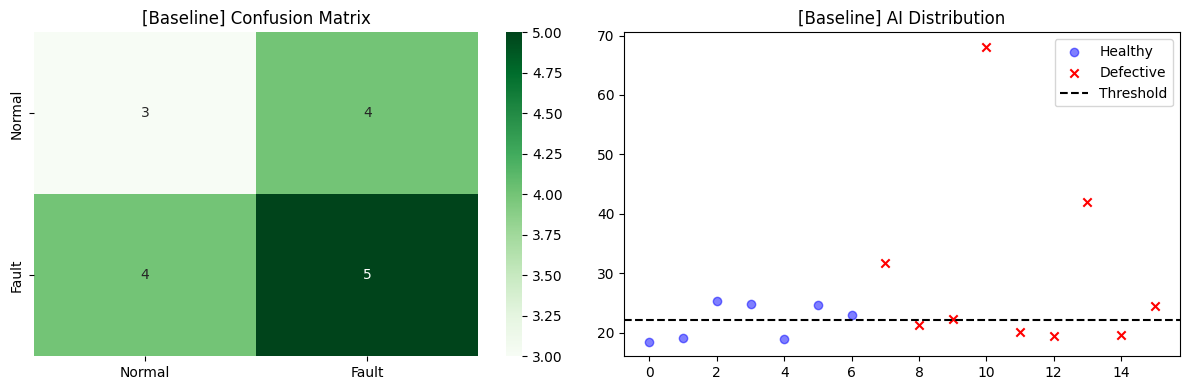

👉 Baseline Accuracy: 50.00%

[Case B] Proposed (10-Fold CV) 정제 및 학습 중...


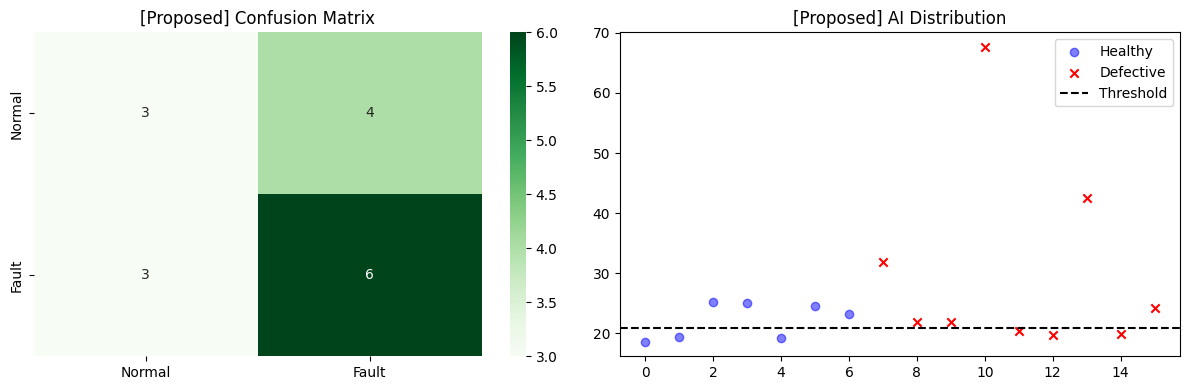

👉 Proposed Accuracy: 56.25%

📊 실험 l31 비교 분석 시작

[Case A] Baseline 학습 중...


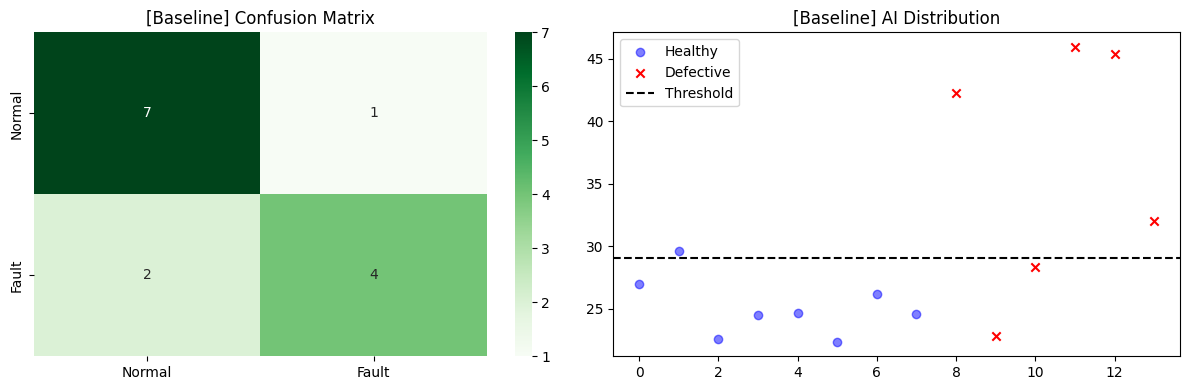

👉 Baseline Accuracy: 78.57%

[Case B] Proposed (10-Fold CV) 정제 및 학습 중...


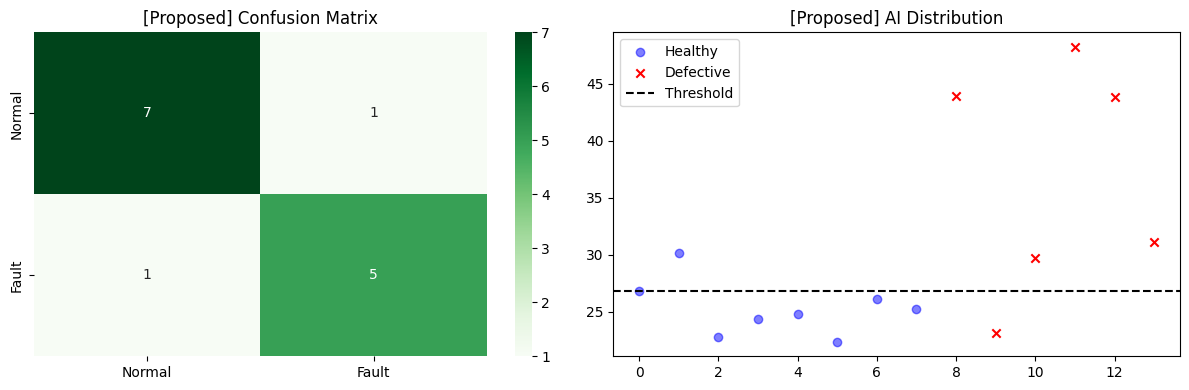

👉 Proposed Accuracy: 85.71%

📊 실험 l33 비교 분석 시작

[Case A] Baseline 학습 중...


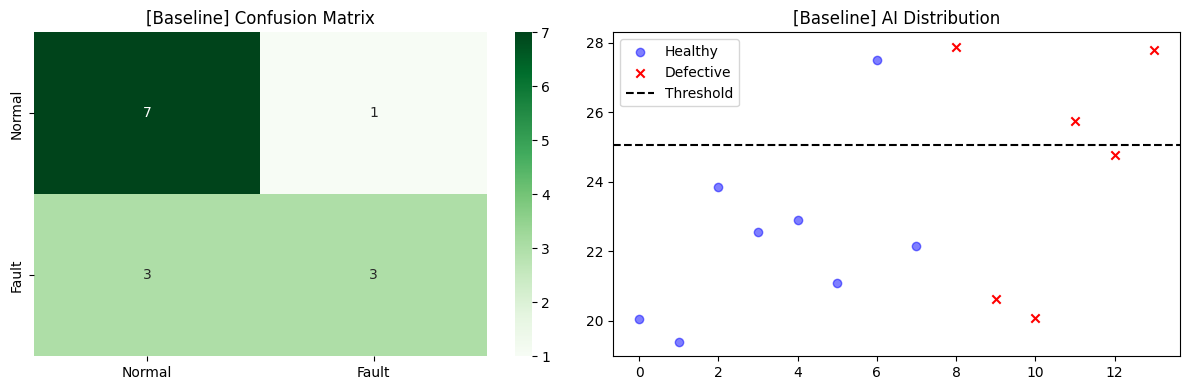

👉 Baseline Accuracy: 71.43%

[Case B] Proposed (10-Fold CV) 정제 및 학습 중...


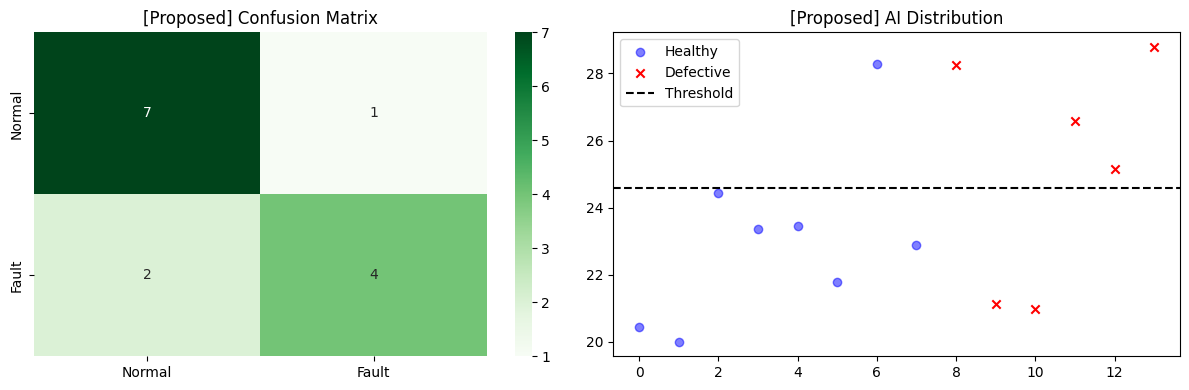

👉 Proposed Accuracy: 78.57%

   Final Comparison Summary
Exp  Baseline  Proposed  Improvement
l29  0.500000  0.562500     0.062500
l31  0.785714  0.857143     0.071429
l33  0.714286  0.785714     0.071429


In [ ]:
# 1. 실험별 최적 파라미터 설정 (루프 밖에서 한 번만 정의)
exp_configs = {
    'l29': {'clean_p': 85, 'thresh_p': 90, 'epochs': 150}, #Cleaning Percentile: 데이터 정제 강도.10-Fold CV 과정에서 학습 데이터 중정상이 아니라고 의심되는 하위 %를 걸러내는 기준
    'l31': {'clean_p': 95, 'thresh_p': 92, 'epochs': 120}, #Threshold Percentile): 불량 판정 기준선. 학습된 모델이 새로운 데이터를 보았을 때, 어느 정도 오차까지 정상으로 인정할지를 정하는 백분위수
    'l33': {'clean_p': 95, 'thresh_p': 95, 'epochs': 120}  #Training Epochs): 학습 반복 횟수.전체 학습 데이터를 모델이 몇 번 반복해서 학습할지를 결정
}     #clean_p: 낮출수록 학습 데이터가 깨끗해지지만 양이 줄어듦. thresh_p: 낮출수록 탐지율은 올라가지만 오보율도 증가함. epochs: 높을수록 정상 데이터 복원력이 정교해짐

comparison_table = []

for exp_id in experiments:
    print(f"\n" + "="*60)
    print(f"📊 실험 {exp_id} 비교 분석 시작")
    print("="*60)

    conf = exp_configs[exp_id]  # 현재 실험 설정 불러오기

    X_train_raw = datasets[exp_id]['train']
    X_test_normal = datasets[exp_id]['test_normal']
    X_test_fault = datasets[exp_id]['test_fault']
    y_true = [1] * len(X_test_normal) + [0] * len(X_test_fault)
    X_test_all = np.concatenate([X_test_normal, X_test_fault], axis=0)
    test_tensor = torch.FloatTensor(X_test_all).to(device)

    # ---------------------------------------------------------
    # [Case A] Baseline: 데이터 정제 없음
    # ---------------------------------------------------------
    print(f"\n[Case A] Baseline 학습 중...")
    model_base = LAM9600_LSTM_AE(n_features=n_feats, seq_len=n_steps).to(device)
    opt_base = optim.Adam(model_base.parameters(), lr=1e-3)
    train_loader_base = DataLoader(TensorDataset(torch.FloatTensor(X_train_raw).to(device)), batch_size=16, shuffle=True)

    for epoch in range(150):
        for batch in train_loader_base:
            opt_base.zero_grad()
            loss = nn.MSELoss()(model_base(batch[0]), batch[0])
            loss.backward()
            opt_base.step()

    model_base.eval()
    with torch.no_grad():
        tr_recon = model_base(torch.FloatTensor(X_train_raw).to(device))
        tr_ai = torch.sum((torch.FloatTensor(X_train_raw).to(device) - tr_recon)**2, dim=(1, 2)).cpu().numpy()
        thresh_base = np.percentile(tr_ai, 90)

        test_recon = model_base(test_tensor)
        ai_base = torch.sum((test_tensor - test_recon)**2, dim=(1, 2)).cpu().numpy()
        pred_base = [0 if s > thresh_base else 1 for s in ai_base]

    acc_base = plot_model_results(exp_id, "Baseline", y_true, pred_base, ai_base, thresh_base)

    # ---------------------------------------------------------
    # [Case B] Proposed: 10-Fold CV 정제 적용 (여기가 Indentation 오류 지점)
    # ---------------------------------------------------------
    print(f"\n[Case B] Proposed (10-Fold CV) 정제 및 학습 중...")
    kf = KFold(n_splits=10, shuffle=True, random_state=42) # 이 줄의 들여쓰기를 맞춤
    bad_indices = []

    for t_idx, v_idx in kf.split(X_train_raw):
        temp_m = LAM9600_LSTM_AE(n_feats, n_steps).to(device)
        temp_opt = optim.Adam(temp_m.parameters(), lr=1e-3)
        X_t = torch.FloatTensor(X_train_raw[t_idx]).to(device)
        X_v = torch.FloatTensor(X_train_raw[v_idx]).to(device)

        temp_m.train()
        for _ in range(20):
            temp_opt.zero_grad()
            loss = nn.MSELoss()(temp_m(X_t), X_t)
            loss.backward(); temp_opt.step()

        temp_m.eval()
        with torch.no_grad():
            recon_v = temp_m(X_v)
            ai_v = torch.sum((X_v - recon_v)**2, dim=(1, 2)).cpu().numpy().flatten()
            p_val = np.percentile(ai_v, conf['clean_p'])

            # 중복 방지를 위해 안전한 필터링 사용
            mask = ai_v > p_val
            bad_indices.extend(v_idx[mask])

    # 중복된 인덱스 제거 후 삭제
    bad_indices = list(set(bad_indices))
    X_train_clean = np.delete(X_train_raw, bad_indices, axis=0)

    model_pro = LAM9600_LSTM_AE(n_features=n_feats, seq_len=n_steps).to(device)
    opt_pro = optim.Adam(model_pro.parameters(), lr=1e-3)
    train_loader_pro = DataLoader(TensorDataset(torch.FloatTensor(X_train_clean).to(device)), batch_size=16, shuffle=True)

    for epoch in range(conf['epochs']):
        for batch in train_loader_pro:
            opt_pro.zero_grad()
            loss = nn.MSELoss()(model_pro(batch[0]), batch[0])
            loss.backward(); opt_pro.step()

    model_pro.eval()
    with torch.no_grad():
        tr_recon_pro = model_pro(torch.FloatTensor(X_train_clean).to(device))
        tr_ai_pro = torch.sum((torch.FloatTensor(X_train_clean).to(device) - tr_recon_pro)**2, dim=(1, 2)).cpu().numpy()
        thresh_pro = np.percentile(tr_ai_pro, conf['thresh_p'])

        test_recon_pro = model_pro(test_tensor)
        ai_pro = torch.sum((test_tensor - test_recon_pro)**2, dim=(1, 2)).cpu().numpy()
        pred_pro = [0 if s > thresh_pro else 1 for s in ai_pro]

    acc_pro = plot_model_results(exp_id, "Proposed", y_true, pred_pro, ai_pro, thresh_pro)

    comparison_table.append({'Exp': exp_id, 'Baseline': acc_base, 'Proposed': acc_pro, 'Improvement': acc_pro - acc_base})

# 최종 결과 출력
df_comp = pd.DataFrame(comparison_table)
print("\n" + "="*60 + "\n   Final Comparison Summary\n" + "="*60)
print(df_comp.to_string(index=False))


📜 [Table] Performance Comparison: Baseline vs. Proposed
Experiment ID  Baseline Accuracy  Proposed Accuracy  Absolute Increase  Improvement_Rate(%)
          l29           0.500000           0.562500           0.062500            12.500000
          l31           0.785714           0.857143           0.071429             9.090909
          l33           0.714286           0.785714           0.071429            10.000000


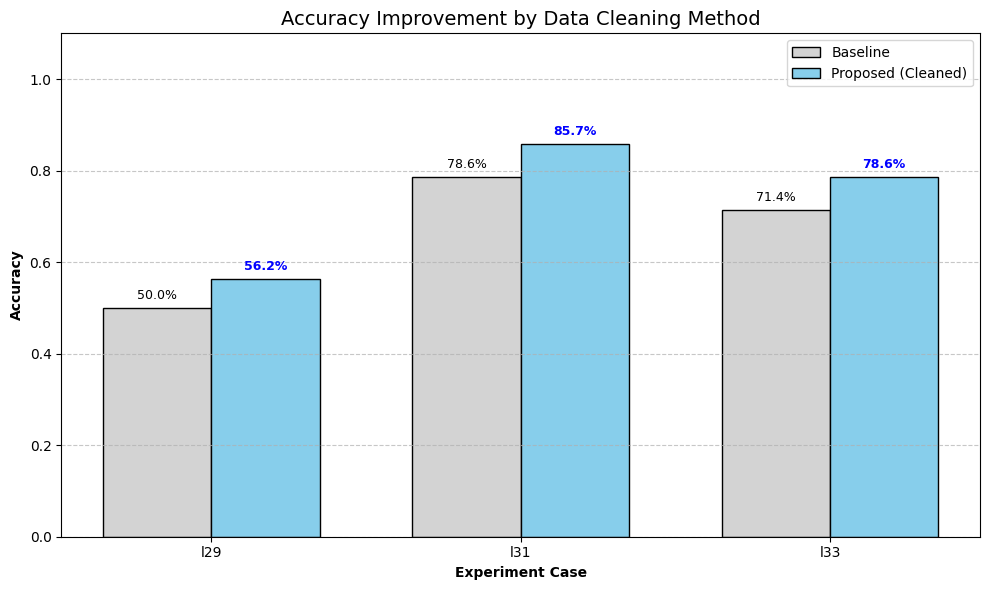

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 1. 개선율(Improvement Rate) 계산 및 테이블화
def generate_final_report(comparison_table):
    df = pd.DataFrame(comparison_table)

    # 성능 향상률 (%) 계산: (Proposed - Baseline) / Baseline * 100
    # 단, Baseline이 0일 경우를 대비해 안전하게 계산
    df['Improvement_Rate(%)'] = df.apply(
        lambda x: ((x['Proposed'] - x['Baseline']) / x['Baseline'] * 100) if x['Baseline'] > 0 else 0, axis=1
    )

    # 논문 형식으로 컬럼명 변경 및 정리
    report_df = df.rename(columns={
        'Exp': 'Experiment ID',
        'Baseline': 'Baseline Accuracy',
        'Proposed': 'Proposed Accuracy',
        'Improvement': 'Absolute Increase'
    })

    print("\n" + "="*70)
    print("📜 [Table] Performance Comparison: Baseline vs. Proposed")
    print("="*70)
    print(report_df.to_string(index=False))

    # 2. 시각화: 정확도 비교 막대 그래프
    plt.figure(figsize=(10, 6))
    bar_width = 0.35
    index = np.arange(len(df))

    plt.bar(index, df['Baseline'], bar_width, label='Baseline', color='lightgrey', edgecolor='black')
    plt.bar(index + bar_width, df['Proposed'], bar_width, label='Proposed (Cleaned)', color='skyblue', edgecolor='black')

    plt.xlabel('Experiment Case', fontweight='bold')
    plt.ylabel('Accuracy', fontweight='bold')
    plt.title('Accuracy Improvement by Data Cleaning Method', fontsize=14)
    plt.xticks(index + bar_width/2, df['Exp'])
    plt.ylim(0, 1.1) # 정확도는 0~1 사이
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # 그래프 위에 수치 표시
    for i in range(len(df)):
        plt.text(i, df['Baseline'][i] + 0.02, f"{df['Baseline'][i]*100:.1f}%", ha='center', fontsize=9)
        plt.text(i + bar_width, df['Proposed'][i] + 0.02, f"{df['Proposed'][i]*100:.1f}%", ha='center', fontsize=9, color='blue', fontweight='bold')

    plt.tight_layout()
    plt.show()

# 함수 실행
generate_final_report(comparison_table)


📈 [Final Summary] Overall Performance with Average
    Exp Baseline Proposed Improvement Improvement_Rate(%)
    l29   0.5000   0.5625      0.0625              12.50%
    l31   0.7857   0.8571      0.0714               9.09%
    l33   0.7143   0.7857      0.0714              10.00%
AVERAGE   0.6667   0.7351      0.0685              10.27%


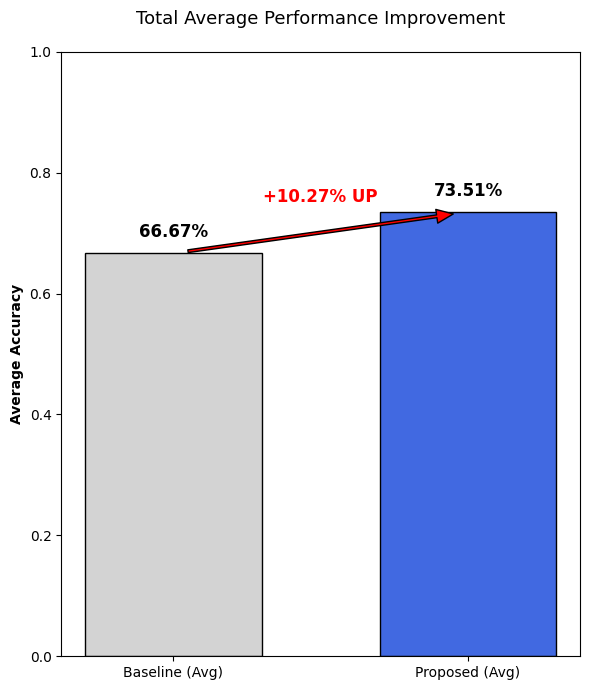

In [ ]:
def generate_final_report_with_mean(comparison_table):
    df = pd.DataFrame(comparison_table)

    # 1. 평균 행(Mean Row) 계산
    mean_baseline = df['Baseline'].mean()
    mean_proposed = df['Proposed'].mean()
    mean_increase = mean_proposed - mean_baseline
    mean_rate = (mean_increase / mean_baseline * 100) if mean_baseline > 0 else 0

    # 2. 결과 테이블 정리
    report_df = df.copy()
    report_df['Improvement_Rate(%)'] = (report_df['Improvement'] / report_df['Baseline'] * 100)

    # 요약 행 추가
    summary_row = pd.DataFrame([{
        'Exp': 'AVERAGE',
        'Baseline': mean_baseline,
        'Proposed': mean_proposed,
        'Improvement': mean_increase,
        'Improvement_Rate(%)': mean_rate
    }])

    final_df = pd.concat([report_df, summary_row], ignore_index=True)

    print("\n" + "="*75)
    print("📈 [Final Summary] Overall Performance with Average")
    print("="*75)
    print(final_df.to_string(index=False, formatters={
        'Baseline': '{:.4f}'.format,
        'Proposed': '{:.4f}'.format,
        'Improvement': '{:.4f}'.format,
        'Improvement_Rate(%)': '{:.2f}%'.format
    }))

    # 3. 평균 성능 비교 시각화 (Bar Chart)
    labels = ['Baseline (Avg)', 'Proposed (Avg)']
    means = [mean_baseline, mean_proposed]

    plt.figure(figsize=(6, 7))
    bars = plt.bar(labels, means, color=['lightgrey', 'royalblue'], edgecolor='black', width=0.6)

    plt.ylabel('Average Accuracy', fontweight='bold')
    plt.title('Total Average Performance Improvement', fontsize=13, pad=20)
    plt.ylim(0, 1.0)

    # 막대 위에 수치 및 향상률 표시
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                 f'{height*100:.2f}%', ha='center', va='bottom', fontsize=12, fontweight='bold')

    # 향상률 화살표 표시
    plt.annotate('', xy=(1, mean_proposed), xytext=(0, mean_baseline),
                 arrowprops=dict(facecolor='red', shrink=0.05, width=2, headwidth=10))
    plt.text(0.5, (mean_baseline + mean_proposed)/2 + 0.05, f'+{mean_rate:.2f}% UP',
             ha='center', color='red', fontweight='bold', fontsize=12)

    plt.tight_layout()
    plt.show()

# 실행
generate_final_report_with_mean(comparison_table)